# Classification for identifying abnormal instances

***
**Contest:** 2023년 지질자원 데이터 활용 및 인공지능 경진대회 (link [here](http://www.geodata-con.kr/2023/overview.php)).  
**Original:** <i><b>A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells</i></b> published in the <i><b>Journal of Petroleum Science and Engineering</i></b> (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).  
**Editor:** Jongwook Kim, Dogyun Kim  
**Advisor:** Jonggeun Choe  
**Last updated:** 08-16-2023
***

# 1. Strategy

#### 1. Load datasets
- <b>Get filenames</b>: First of all, we need to get all the filenames we used.
- <b>Load datasets</b>: Datasets will be loaded from csv files using pandas package. And merge all the datasets to unified dataset.
#### 2. Pre-processing - feature level
- <b>Response variables selection</b> We need to check which variables could be helpful in our analysis. Response variables had small size & variance will be dropped.
- <b>Logical treshold</b> will be applied at the dataset we used. It means non-logical values of the pressure (minus values) will be discarded and hard-outlier will also be eliminated or treated apparently. The thresholds are determined by conducting EDA.
#### 3. Pre-processing - sample level
- <b>Data cleaning</b> There's frozen variables & missing values in each instance. Frozen variables will be transformed to '0' values. And, missing values will be applied to linear interpolation.
#### 4. Train model
- <b>Feature engineering</b> will be conducted for feature extraction of time series data. It includes lengths, mean, std, etc.
- <b>RF classifier</b> will be trained using simulated & drawn data and data augmentation.   

# 2. Imports and Configurations

In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch.cuda
%load_ext autoreload
%autoreload 2
from pathlib import Path
from module import *
from argparse import ArgumentParser
from models import *
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from copy import copy

from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

data_path = Path('data')
fix_seed()
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']

#parsing the parameters
args = ArgumentParser()
args.columns = ['timestamp'] + vars + ['class']
args.abnormal_classes_codes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
args.downsample_rate = 30            # Adjusts frequency of sampling to the dynamics
                                # of the undesirable event of interest
args.sample_size_default = 60        # In observations (after downsample)
args.sample_size_normal_period = 5   # In observations (after downsample)
args.max_nan_percent = 0.15           # For selection of useful variables
args.std_vars_min = 0.01             # For selection of useful variables
args.max_frozen_percent = 0.1
args.disable_progressbar = True      # For less output

df_instances_clean, clean_vars, instances, real_instances, sim_instances, drawn_instances = Preprocessing(args, vars, data_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
number of total instances = 1984
number of real instances = 1025
number of simulated instances = 939
number of drawn instances = 20

Clean Variables: ['P-TPT', 'T-TPT', 'P-MON-CKP']


#### Classification using TSFresh

In [20]:
# df_fc_p = {
#     "abs_energy": None,
#     "absolute_maximum": None,
#     "absolute_sum_of_changes": None,
#     "cid_ce": [{"normalize": False}],
#     "count_above_mean": None,
#     "count_below_mean": None,
#     "first_location_of_maximum": None,
#     "first_location_of_minimum": None,
#     "kurtosis": None,
#     "large_standard_deviation": [{"r": 0.25}],
#     "last_location_of_maximum": None,
#     "last_location_of_minimum": None,
#     "longest_strike_above_mean": None,
#     "longest_strike_below_mean": None,
#     "maximum": None,
#     "mean": None,
#     "mean_abs_change": None,
#     "mean_change": None,
#     "mean_second_derivative_central": None,
#     "median": None,
#     "minimum": None,
#     "root_mean_square": None,
#     "skewness": None,
#     "standard_deviation": None,
#     "variance": None
# }
#
# df_fc_p.pop('count_above_mean')
# df_fc_p.pop('count_below_mean')

df_fc_p = {
    "abs_energy": None, # P-TPT, T-TPT
    "absolute_maximum": None, # P-TPT, T-TPT
    "last_location_of_maximum": None, # P-TPT, T-TPT
    "mean_abs_change": None, # P-TPT
    "minimum": None, # T-TPT
    "mean": None, # T-TPT
    "skewness": None, # T-TPT, P-MON-CKP
}

print(df_fc_p.keys())

dict_keys(['abs_energy', 'absolute_maximum', 'last_location_of_maximum', 'mean_abs_change', 'minimum', 'mean', 'skewness'])


In [21]:
df_real = df_instances_clean[df_instances_clean['source']=='real']
# X (real)
real_id = list(set(df_real['instance_id']))
# Y (real)
real_class= list(instances.loc[real_id]['class_code'])

df_sim = df_instances_clean[df_instances_clean['source']=='simulated']
sim_id = list(set(df_sim['instance_id']))
sim_class= list(instances.loc[sim_id]['class_code'])


df_drawn = df_instances_clean[df_instances_clean['source']=='drawn']
drawn_id = list(set(df_drawn['instance_id']))
drawn_class= list(instances.loc[drawn_id]['class_code'])

df_synthetic = pd.concat([df_sim, df_drawn], axis=0).reset_index(drop=True)
synthetic_id = sim_id + drawn_id
synthetic_class = sim_class + drawn_class

### Data Augmentation

In [22]:
df = copy(df_instances_clean)
df.loc[df['source']=='drawn', ['P-TPT', 'P-MON-CKP']] = df.loc[df['source']=='drawn', ['P-TPT', 'P-MON-CKP']] * 1e5
new_instances = copy(instances)

df, new_instances = make_augmentation(df, new_instances, real_instances, sim_instances, drawn_instances)
add_instances = new_instances[1984:]

### Stratified sampling

In [23]:
args.train_ratio = 0.6
args.validation_ratio = 0.2
args.test_ratio = 0.2
RF = True
use_synthetic = True
use_augmentation = True
integrate = False
integrate_syn = False
# Real_Only | With_Sim_Drawn | With_Sim_Drawn_Augmentation
# 첫번째 Each => scaler를 real이랑 synthetic이랑 분리
# 두번째 Each => scaler를 synthetic 내에서 simulatd랑 drawn이랑 분리
name = 'Each_Each_With_Sim_Drawn_Augmentation'

Real instances에서 train과 test를 나누고, 여기서 simulated와 drawn은 train에만 넣어줌

In [24]:
fix_seed()
train_id, test_id = [], []
real_idx_dict = {}
for class_code in set(real_instances['class_code']):
    real_idx_dict[class_code] = list(real_instances[real_instances['class_code'] == class_code].index.values)

for class_code in set(real_instances['class_code']):
    # 2023-08-11: Compatible with Simulated and Drawn dataset
    if ceil(args.test_ratio * len(real_instances[real_instances['class_code'] == class_code])) <= 1:
        class_tmp = [int(real_idx_dict[class_code].pop(np.random.randint(len(real_idx_dict[class_code]))))]
        test_id += class_tmp
        train_id += real_idx_dict[class_code]
        if use_synthetic:
            train_id += list(sim_instances[sim_instances['class_code'] == class_code].index.values + 1025)
            train_id += list(drawn_instances[drawn_instances['class_code'] == class_code].index.values + 1964)
        if use_augmentation:
            train_id += list(add_instances[add_instances['class_code'] == class_code].index.values)
    else:
        test_id_class = np.random.choice(real_idx_dict[class_code], size=ceil(args.test_ratio * len(real_instances[real_instances['class_code'] == class_code])), replace=False)
        test_id += list(test_id_class)
        train_id += list(set(real_idx_dict[class_code]) - set(test_id_class))
        if use_synthetic:
            train_id += list(sim_instances[sim_instances['class_code'] == class_code].index.values + 1025)
            train_id += list(drawn_instances[drawn_instances['class_code'] == class_code].index.values + 1964)
        if use_augmentation:
            train_id += list(add_instances[add_instances['class_code'] == class_code].index.values)
train_id = sorted(train_id)
test_id = sorted(test_id)
print(f'Train ratio: {len(train_id) / len(train_id+test_id):.2f}')
print(f'Test ratio: {len(test_id) / len(train_id+test_id):.2f}')

Train ratio: 0.91
Test ratio: 0.09


### Train & Test 데이터프레임을 만들고, 스케일링

In [25]:
df_train = make_data(df, train_id)
y_train = new_instances.loc[train_id, 'class_code']
df_test = make_data(df, test_id)
y_test = new_instances.loc[test_id, 'class_code']
if integrate:
    scaler_train = make_scaler(train_id, df_train, clean_vars)
    df_train = fit_scaler_old(train_id, df_train, clean_vars, scaler_train)
    df_test = fit_scaler_old(test_id, df_test, clean_vars, scaler_train)
else:
    train_id = np.array(train_id)
    train_id_real = train_id[train_id < 1025]
    scaler_train_real = make_scaler(train_id_real, df_train, clean_vars)
    df_train = fit_scaler_old(train_id_real, df_train, clean_vars, scaler_train_real)
    df_test = fit_scaler_old(test_id, df_test, clean_vars, scaler_train_real)

    if integrate_syn:
        train_id_syn = train_id[train_id >= 1025]
        scaler_train_syn = make_scaler(train_id_syn, df_train, clean_vars)
        df_train = fit_scaler_old(train_id_syn, df_train, clean_vars, scaler_train_syn)
    else:
        train_id_sim = set(df_train.loc[df_train['source']=='simulated', 'instance_id'])
        train_id_drawn = set(df_train.loc[df_train['source']=='drawn', 'instance_id'])

        scaler_train_sim = make_scaler(train_id_sim, df_train, clean_vars)
        scaler_train_drawn = make_scaler(train_id_drawn, df_train, clean_vars)

        df_train = fit_scaler_old(train_id_sim, df_train, clean_vars, scaler_train_sim)
        df_train = fit_scaler_old(train_id_drawn, df_train, clean_vars, scaler_train_drawn)


### TSFRESH를 이용하여 시퀀스의 통계적 특징 추출

In [27]:
X_train_raw = df_train.drop(['class', 'source'], axis=1)
X_test_raw = df_test.drop(['class', 'source'], axis=1)

# TSFRESH
X_train = extract_features(X_train_raw, column_id='instance_id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=args.disable_progressbar).reset_index(drop=True)
X_test = extract_features(X_test_raw, column_id='instance_id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=args.disable_progressbar).reset_index(drop=True)

print(f'X_train: {len(X_train)}\ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}')
# X_train
# train_id
len(train_id)

X_train: 2034
y_train: 2034
X_test: 209
y_test: 209


2034

In [55]:
 a.loc[a['class'] > 100,:]

,timestamp,P-TPT,T-TPT,P-MON-CKP,class
332208,2014-01-24 21:47:36.000000,0.957028,0.455826,1.060966,101.0
332209,2014-01-24 21:48:06.000000,0.957028,0.455826,1.060068,101.0
332210,2014-01-24 21:48:36.000000,0.955939,0.455826,1.034161,101.0
332211,2014-01-24 21:49:06.000000,0.954731,0.455826,1.008254,101.0
332212,2014-01-24 21:49:36.000000,0.953521,0.455826,0.983021,101.0
...,...,...,...,...,...
468597,2017-05-09 08:07:17.000000,-2.766585,-4.251805,-0.604637,108.0
468598,2017-05-09 08:07:47.000000,-2.766585,-4.251985,-0.607813,108.0
468599,2017-05-09 08:08:17.000000,-2.766585,-4.252677,-0.609679,108.0
468600,2017-05-09 08:08:47.000000,-2.766585,-4.251650,-0.608401,108.0


In [56]:
a = df_train[df_train['source']=='real'].drop(['source', 'instance_id'], axis=1).fillna(method='bfill')
a.loc[a['class'] > 100,'class'] = a.loc[a['class'] > 100,'class'].astype(int) - 100


In [57]:
extract_features(a, column_id='class', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=args.disable_progressbar).reset_index(drop=True)

,P-TPT__abs_energy,P-TPT__absolute_maximum,P-TPT__last_location_of_maximum,P-TPT__mean_abs_change,P-TPT__minimum,P-TPT__mean,P-TPT__skewness,T-TPT__abs_energy,T-TPT__absolute_maximum,T-TPT__last_location_of_maximum,...,T-TPT__minimum,T-TPT__mean,T-TPT__skewness,P-MON-CKP__abs_energy,P-MON-CKP__absolute_maximum,P-MON-CKP__last_location_of_maximum,P-MON-CKP__mean_abs_change,P-MON-CKP__minimum,P-MON-CKP__mean,P-MON-CKP__skewness
0,309509.509835,2.766585,0.013435,0.454689,-2.766585,-0.109460,0.112331,108729.534456,4.437548,0.138818,...,-4.437548,0.316129,-7.564046,312428.684572,1.785222,0.749671,0.515568,-1.204516,-0.091538,0.793799
1,1489.729326,1.432554,0.819167,0.001427,0.147020,0.849068,-0.191643,479.215600,0.560373,0.804906,...,0.455826,0.521818,-0.310328,1010.553781,1.238662,0.857387,0.002749,-0.639992,0.160447,0.220907
2,1989.662042,2.228975,0.062930,0.020463,-1.859400,-0.132952,0.026292,34347.467995,4.301735,0.000344,...,-4.301735,-3.233866,1.449606,3450.403550,1.204516,0.000344,0.005642,-1.204516,-0.860138,1.818799
3,1403.891361,0.730309,0.308177,0.005970,-0.730309,0.229665,0.090899,76798.618912,3.969052,0.022835,...,-3.969052,-2.186896,3.223939,7889.290249,0.951326,0.711578,0.022632,-0.951326,-0.642018,1.842938
4,29433.968803,2.766585,0.632646,0.023366,-2.766585,0.472826,-0.968263,120822.797848,4.437548,0.000091,...,-4.437548,-0.536645,-0.943093,36494.384475,1.696743,0.632616,0.038906,-0.726917,0.520874,0.216839
5,10499.199941,2.766585,0.000106,0.001202,-2.766585,-0.784272,-0.410704,12989.015520,4.437548,0.773264,...,-4.437548,-0.812194,-3.141581,2426.241033,1.018296,0.003403,0.014354,-1.018296,-0.200931,0.005086
6,3.562105,0.159126,1.000000,0.001001,-0.159126,-0.084357,-0.827663,105.424358,0.545644,0.854118,...,0.024793,0.466667,-2.094873,73.548790,0.699402,0.988235,0.003725,-0.699402,-0.340823,1.830643
7,9432.763158,1.432554,1.000000,0.000735,-1.006995,0.727123,-0.846333,1427.768378,0.512666,0.550153,...,0.142340,0.447521,-1.806820,8580.485761,1.478697,0.994037,0.002376,-0.698341,0.799138,-0.834955
8,9230.713430,2.766585,1.000000,0.000000,-2.766585,-2.766585,0.000000,17293.156933,4.256674,0.003317,...,-4.256674,-3.758021,2.360769,639.407789,0.986908,0.999171,0.006885,-0.986908,-0.697269,0.219487


#### Random Forest classifier with Bayesian optimization

In [9]:
from sklearn.metrics import accuracy_score
hyper = {'n_estimators':(50,1000), 'max_depth':(5, 50), 'min_samples_leaf':(2,50), 'min_samples_split':(2,50)}
hyper_type = round

def objective(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    for param in hyper.keys():
        hyper[param] = hyper_type(eval(param))
    RF_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                     max_depth=int(max_depth),
                                     min_samples_leaf=int(min_samples_leaf),
                                     min_samples_split=int(min_samples_split),
                                     random_state=0)
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    colums_class = ['True', 'Pred']
    df_class = pd.DataFrame(columns=colums_class)
    df_class['True'] = y_test
    df_class['Pred'] = y_pred
    #ret = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')
    ret = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='macro')
    p, r, f1, _ = ret
    return np.average(f1)

BO = BayesianOptimization(f= objective, pbounds=hyper)
acquisition_function = UtilityFunction(kind='ei', xi=0.0001)
BO.maximize(init_points=15, n_iter=40, acquisition_function=acquisition_function)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.6686    | 7.331     | 3.42      | 34.58     | 111.8     |
| 2         | 0.5797    | 40.61     | 25.45     | 38.85     | 85.21     |
| 3         | 0.5594    | 20.01     | 37.24     | 32.15     | 897.9     |
| 4         | 0.6752    | 30.49     | 9.823     | 12.7      | 951.7     |
| 5         | 0.6389    | 15.5      | 21.73     | 39.02     | 258.7     |
| 6         | 0.5802    | 19.78     | 29.44     | 21.36     | 307.1     |
| 7         | 0.5829    | 16.03     | 22.23     | 39.55     | 521.6     |
| 8         | 0.5802    | 13.25     | 36.0      | 23.34     | 565.3     |
| 9         | 0.5309    | 49.72     | 44.0      | 26.73     | 279.0     |
| 10        | 0.788     | 29.95     | 3.329     | 10.87     | 662.1     |
| 11        | 0.6686    | 44.72     | 8.386     | 41.44     | 594.2     |
| 12        | 0.5802    | 10.2      | 

In [10]:
params_opt = {}
for param in BO.max['params'].keys():
    params_opt[param] = int(BO.max['params'][param])

RF_model = RandomForestClassifier(n_estimators=params_opt['n_estimators'],
                                     max_depth=params_opt['max_depth'],
                                     min_samples_leaf=params_opt['min_samples_leaf'],
                                     min_samples_split=params_opt['min_samples_split'],
                                     random_state=0)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
colums_class = ['True', 'Pred']
df_class = pd.DataFrame(columns=colums_class)
df_class['True'] = y_test
df_class['Pred'] = y_pred
precision, recall, f1, acc = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='macro')
acc = accuracy_score(df_class['True'], df_class['Pred'])

# print('{:>10} : {:.2f}'.format( 'accuracy', accuracy ) )
print('{:>10} : {:.3f}'.format( 'precision', np.average(precision) ) )
print('{:>10} : {:.3f}'.format( 'recall', np.average(recall) ) )
print('{:>10} : {:.3f}'.format( 'f1', np.average(f1) ) )
print('{:>10} : {:.3f}'.format( 'accuracy', np.average(acc) ) )

 precision : 0.939
    recall : 0.904
        f1 : 0.899
  accuracy : 0.976


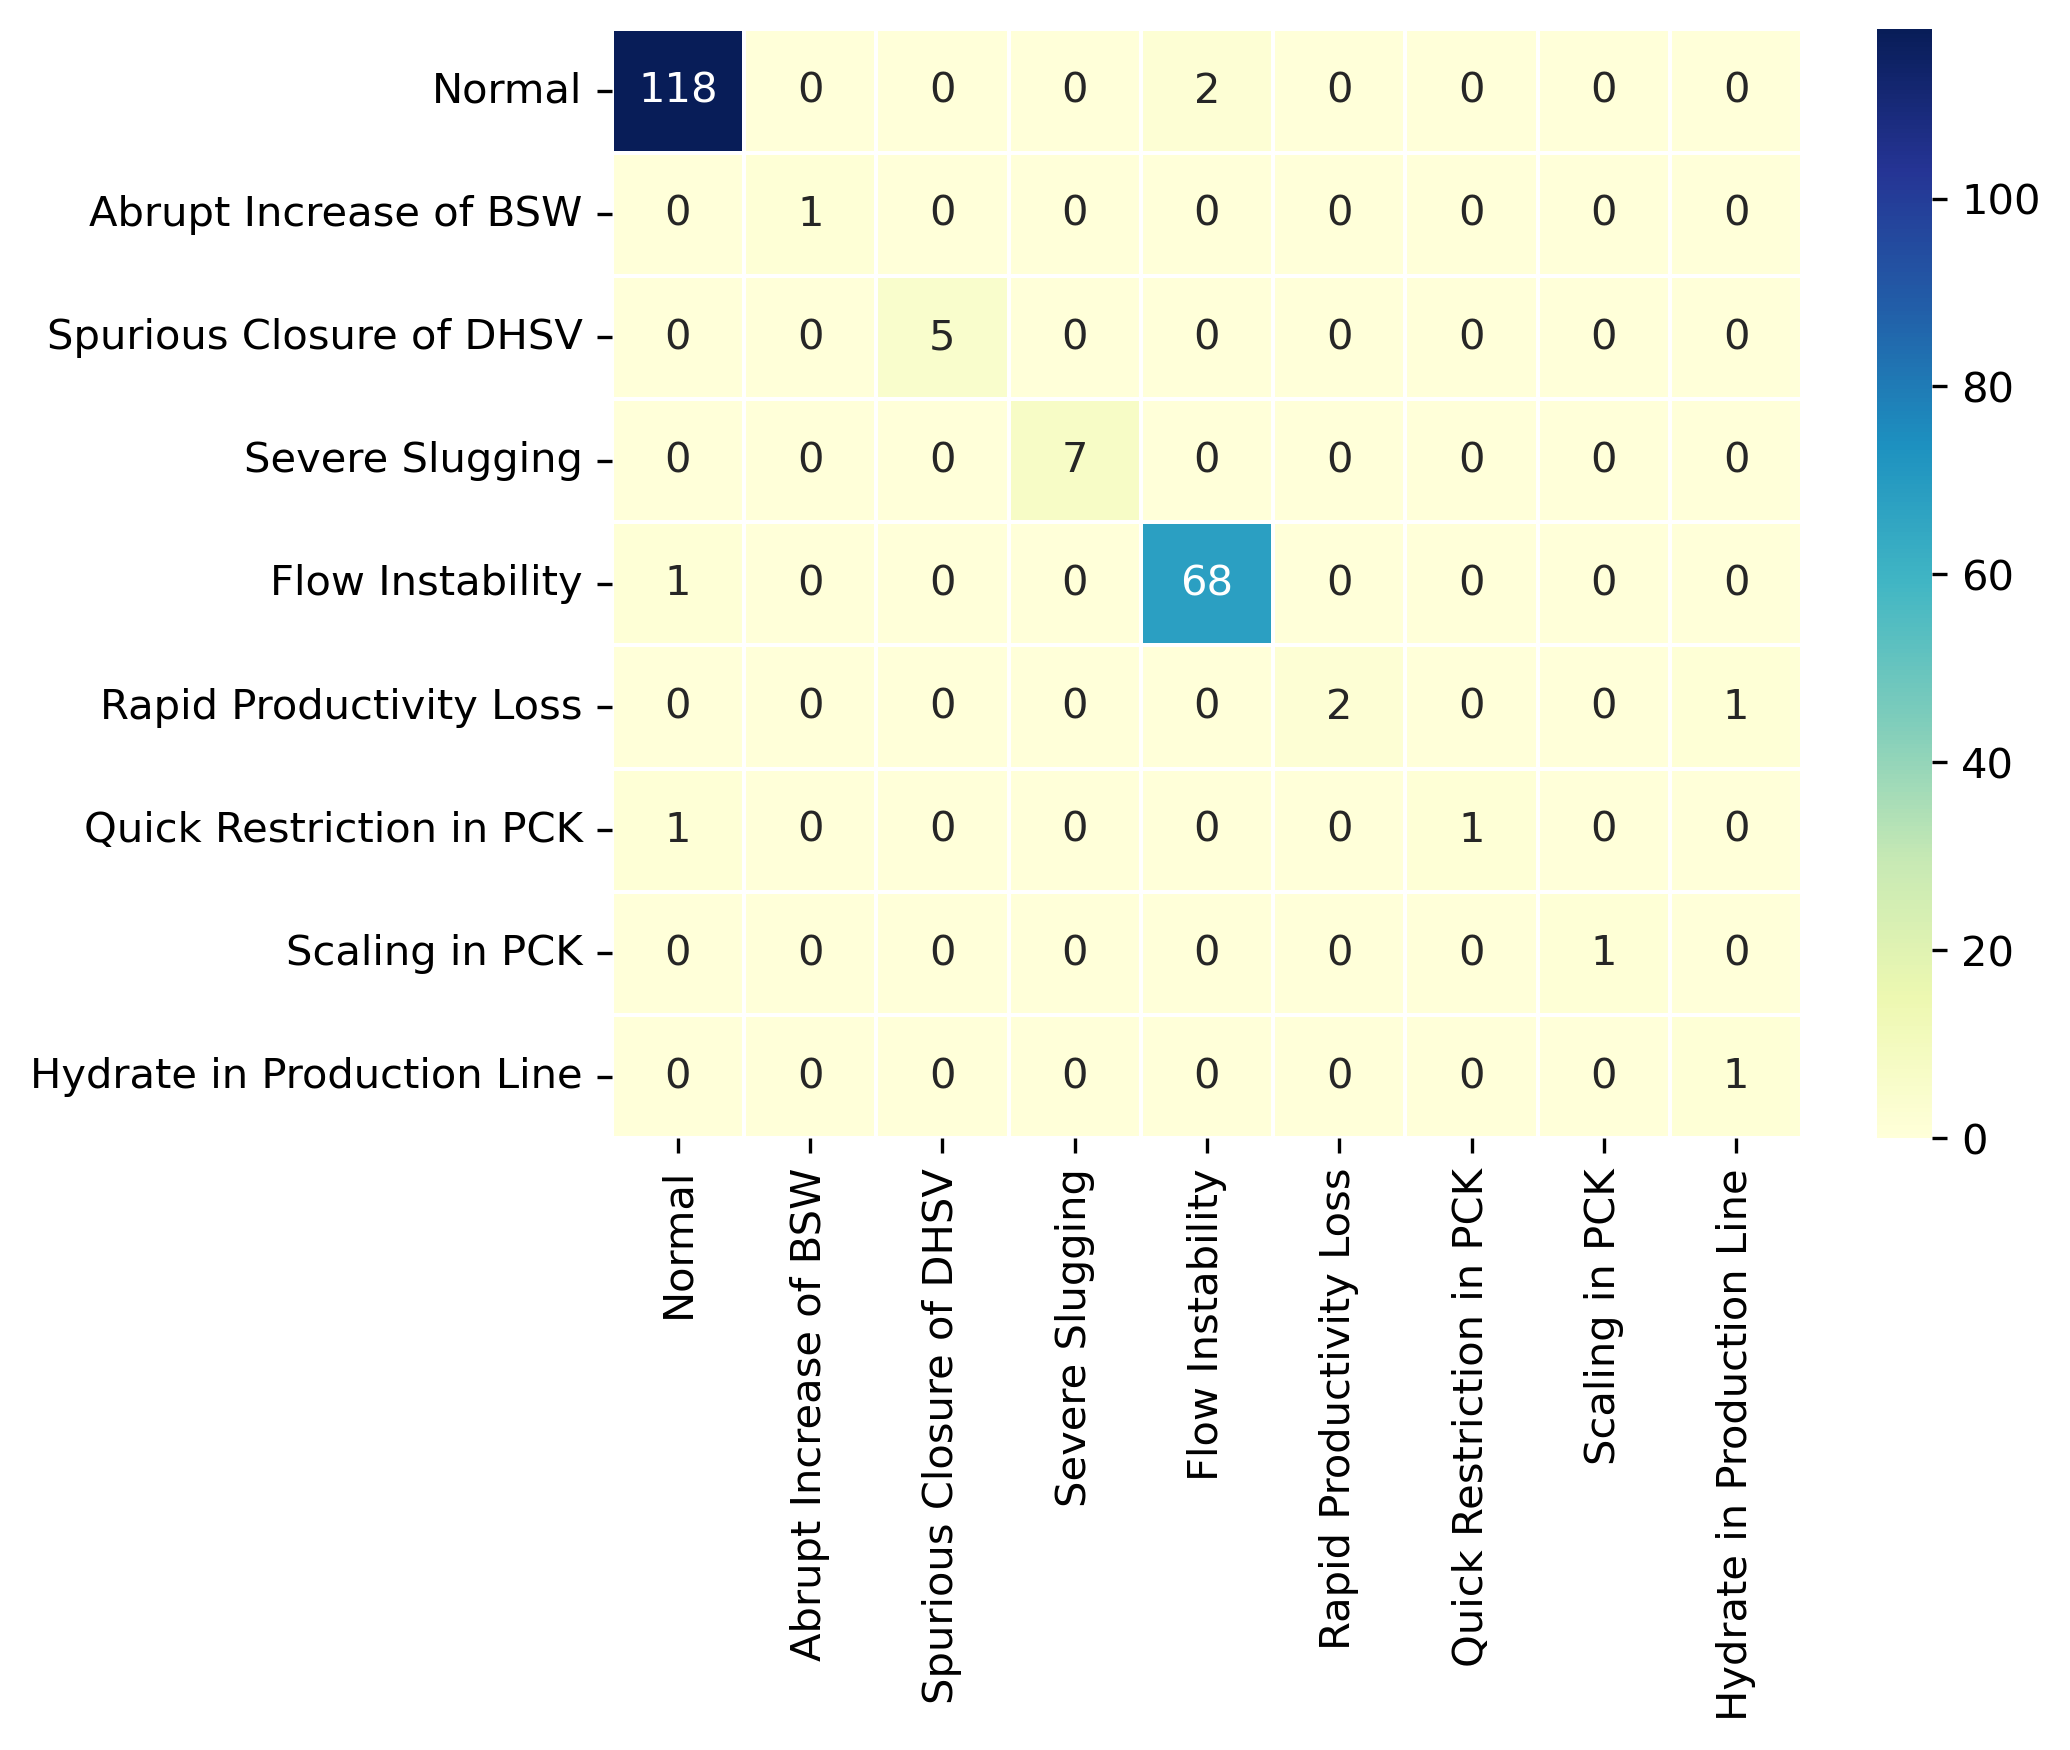

In [13]:
# labels = [events_names[n] for n in list(set(instances.loc[list(set(X_test_raw['instance_id']))]['class_code']))]
labels = [events_names[n] for n in list(set(instances.loc[test_id]['class_code']))]
conf_m = confusion_matrix(df_class['True'] , df_class['Pred'] )
plt.rcParams['figure.dpi'] = 300
sns.heatmap(
    conf_m,xticklabels= labels, yticklabels=labels,
    linewidths=.5, annot=True, cmap = "YlGnBu",fmt="d")
if not 'fig' in os.listdir():
    os.mkdir('fig')
    if not 'Mission1' in os.listdir('fig'):
        os.mkdir('./fig/Mission1')
plt.savefig(f'./fig/Mission1/test_results_{name}_{np.average(f1):.3f}.png',bbox_inches = 'tight')
plt.show()

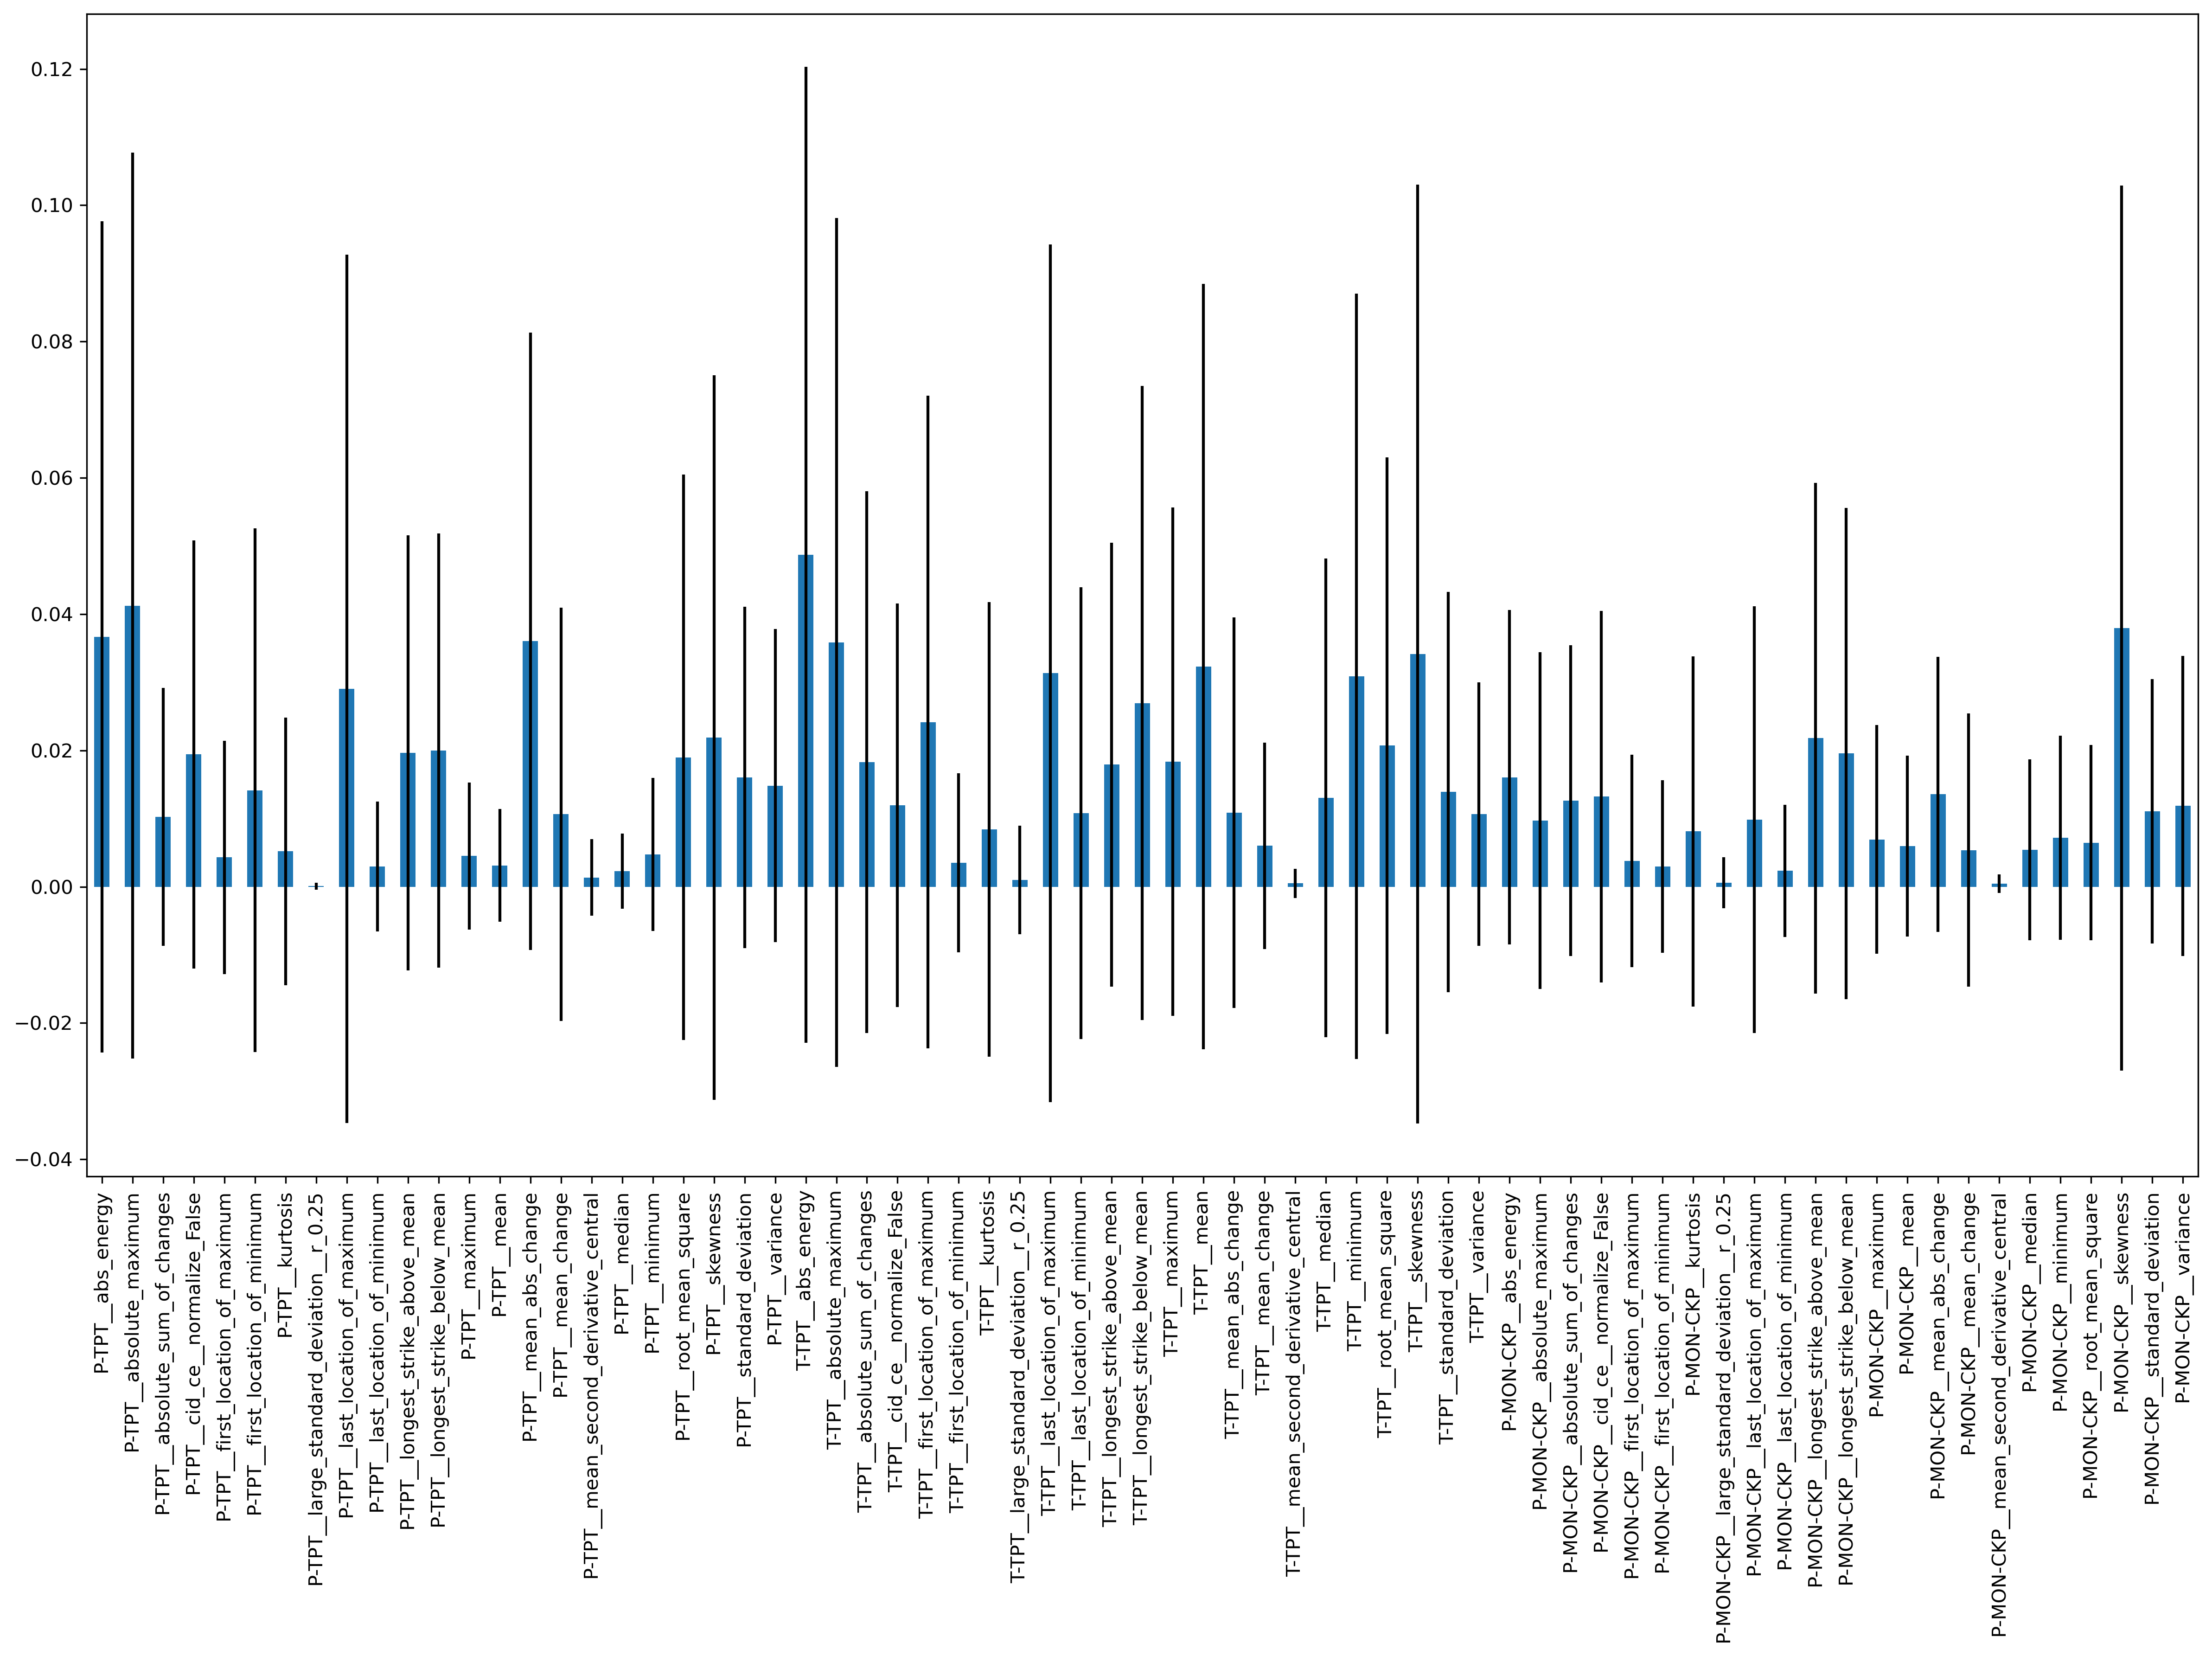

In [15]:
f_importances = pd.Series(RF_model.feature_importances_, index = X_train.columns)
std  = np.std([estimator.feature_importances_ for estimator in RF_model.estimators_], axis=0)
fig, ax = plt.subplots(figsize = (16, 12))
# plt.figure(figsize = (16,12))
f_importances.plot.bar(yerr=std, ax=ax)
fig.tight_layout()
plt.savefig('./fig/Mission1/Feature_importance.png')